# COMS3007 - Machine Learning - Inference Coursework

## Setup

For all of the questions in this coursework we used the following Python packages:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from ipywidgets import widgets
from IPython.display import display

Several functions were used to add noise and setup the input images:

In [17]:
def add_gaussian_noise(im,prop,varSigma):
    ########################################################################################
    # add_gaussian_noise - Created image with addition of Gaussina noise
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma ->
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2 = np.float64(im2)
    im2[index] += e[index]
    
    return im2

def add_saltnpeppar_noise(im,propSP):
    ########################################################################################
    # add_saltnpeppar_noise - Created image with addition of salt and pepper noise (flipped pixels)
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*propSP))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]

    return im2

def setup_image(img, prop, varSigma, propSP):
    ########################################################################################
    # setup_image - Creates different noisy images and sets noisy and latent images
    #   Inputs:
    #       img -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma -> variance of gaussian noise
    #       level -> level of noise (gaussian, saltnpepper, both)
    #   Outputs:
    #      orgImg -> original grayscale image
    #      im2 -> gaussian noise image
    #      im3 -> salnpepper noise image
    #      im4 -> gaussian and slatnpepper noise image
    #      yImg -> noisy image
    #      xImg -> latent image
    ########################################################################################
    # read image and set values to +1 -1
    orgImg = imread(img)  # original image
    orgImg = np.asarray(orgImg, int)
    orgImg[orgImg < np.mean(orgImg)] = -1
    orgImg[orgImg >= np.mean(orgImg)] = 1

    # add noise to original image
    im2 = add_gaussian_noise(orgImg, prop, varSigma)  # gaussian noise
    im3 = add_saltnpeppar_noise(orgImg, propSP)  # salt and pepper noise
    im4 = add_saltnpeppar_noise(im2, propSP)  # gaussian + salt and pepper noise

    yImg = np.array(im4)  # noisy image
    xImg = yImg  # latent image
    
    return orgImg, im2, im3, im4, yImg, xImg

Some other functions were used throughout the questions:

In [3]:
def neighbours(i,j,M,N,size=4):
    ########################################################################################
    # neighbours - Finds the neighbours of a node
    #   Inputs:
    #       i -> x position
    #       j -> y position
    #       M -> size of image in X
    #       N -> size of image in Y
    #       size -> 4 doesn't include diagonals, 8 does include diagonals
    #   Outputs:
    #       n -> array containing coordinates of neighbours
    ########################################################################################
    if size==4:
        if (i==0 and j==0):
             n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n

    if size==8:
        if (i==0 and j==0):
             n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1), (1,N-2)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0), (M-2,1)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1), (M-2,N-2)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j), (1,j+1), (1,j-1)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1,j+1)]

        return n

def energy(noisyImg,latentImg,x,y,consts):
    ########################################################################################
    # energy - Calculates energy function
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       e -> energy of current state
    ########################################################################################
    e = consts[0]*latentImg[x,y] # h*sumXi
    e += -consts[2]*latentImg[x,y]*noisyImg[x,y] # -n*sumXiYi

    neighbour = neighbours(x, y, latentImg.shape[0], latentImg.shape[1], size=8)

    for ii in range(len(neighbour)):
        e += -consts[1]*latentImg[x,y]*latentImg[neighbour[ii]]

    return e

def convergence_rate(xImg,orgImg):
    ########################################################################################
    # convergence_rate - Calculates the percentage of pixels that are correct in the de-noised image
    #   Inputs:
    #       xImg -> latent image
    #       orgImg -> original image
    #   Outputs:
    #       convergence_rate -> percentage of pixels in xImg that are the same as in orgImg
    ########################################################################################
    convergence_rate = float(np.sum(xImg == orgImg)) / orgImg.size * 100.00
    return convergence_rate

def final_plot(orgImg, im2, im3, im4,xImg, level):
    ########################################################################################
    # final_plot - Plot original image, noisy image and de-noised image
    #   Inputs:
    #       orgImg -> original image
    #       im2 -> gaussian noise image
    #       im3 -> salt n pepper noise image
    #       im4 -> both gaussian and salt n pepper noise image
    #       xImg -> latent image
    #       level -> level of noise (guassian, saltnpepper, both)
    #   Outputs:
    #       plots original, noisy and de-noised image
    ########################################################################################
    noisy_im = im4
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(orgImg,cmap='gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(noisy_im,cmap='gray')
    axarr[1].set_title('Noisy Image')
    axarr[2].imshow(xImg,cmap='gray')
    axarr[2].set_title('De-noised Image')
    
    plt.show()

The convergence_rate function calculates the percentage of pixels in the de-noised image that are the same as the original image; this acts as a good quantitative measure of algorithm performance.

## Question 1 - Iterative Conditional Models (ICM)

The functions to implement ICM are as follows:

In [4]:
def totalEnergy(noisyImg,latentImg,consts):
    ########################################################################################
    # totalEnergy - Calculates total energy for whole image
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       totalE -> total energy of image in current state
    ########################################################################################
    totalE = 0

    for i in range(latentImg.shape[0]):
        for j in range(latentImg.shape[1]):
            totalE += energy(noisyImg,latentImg,i,j,consts)

    return totalE


def icm(image,noise,consts,plot_all_flag=0):
    ########################################################################################
    # icm - Calculates best value of pixel for current state using ICM algorithm
    #   Inputs:
    #       image -> noisy image
    #       prop -> proportion of pixels to flip for noisy image
    #       varSigma -> variance of gaussian noise
    #       level -> type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    # calculate total energy of noisy image
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE
    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
    print("Iteration: ")
    for i in range(T):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):

                orgEnergy = energy(yImg, xImg, x, y, consts)
                diffEnergy = totalE - orgEnergy

                testLatentImg1 = np.copy(xImg)
                testLatentImg2 = np.copy(xImg)

                testLatentImg1[x, y] = -1
                testLatentImg2[x, y] = 1

                tstEnergy1 = energy(yImg, testLatentImg1, x, y, consts)
                tstEnergy2 = energy(yImg, testLatentImg2, x, y, consts)

                if tstEnergy1 < tstEnergy2:
                    xImg = testLatentImg1
                    totalE = diffEnergy + tstEnergy1
                elif tstEnergy2 < tstEnergy1:
                    xImg = testLatentImg2
                    totalE = diffEnergy + tstEnergy2
        
        if plot_all_flag == 1:
            plotICM(xImg,i)
        # break loop if energy hasn't been reduced since previous iteration
        if totalE == currentE:
            print("Converged")
            print("Number of iterations to converge: ", i + 1)
            print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            break
        currentE = totalE
        print((i+1), end=" ")

    # Plot original image, noisy image and de-noised image
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])
    
def plotICM(latentImg,i):
    ########################################################################################
    # plotICM - Plots de-noised image 
    #   Inputs:
    #       latentImg -> latent image
    #       i -> number of iterations
    #   Outputs:
    #       plots and saves input image
    ########################################################################################
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(latentImg, cmap='gray')
    ax.set_title('De-noised Image (%d iterations)' % (i+1), fontsize=16)
#     f.savefig('icm%diterations.png' % i)
    # plt.show()
    return -1

## Questions 2-4 - Gibbs Sampling

The functions to implement Gibbs Sampling are as follows:

In [9]:
def gibbs(noisyImg,latentImg,x,y,consts,totalE):
    ########################################################################################
    # gibbs - Calculates best value of pixel for current state using gibbs sampling
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #       totalE -> total energy of image
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    ########################################################################################
    orgEnergy = energy(noisyImg, latentImg, x, y, consts)
    diffEnergy = totalE - orgEnergy

    testLatentImg1 = np.copy(latentImg)
    testLatentImg2 = np.copy(latentImg)

    testLatentImg1[x, y] = 1
    testLatentImg2[x, y] = -1

    tstEnergy1 = energy(noisyImg, testLatentImg1, x, y, consts)
    tstEnergy2 = energy(noisyImg, testLatentImg2, x, y, consts)

    px1 = np.exp(-tstEnergy1) / (np.exp(-tstEnergy2) + np.exp(-tstEnergy1)) # p(x_i=1 | x_\i,y_i)

    # t = np.random.uniform(0,1)
    t = np.random.uniform(0.4, 0.6)

    if px1 > t:
        latentImg = testLatentImg1
        totalE = diffEnergy + tstEnergy1
    else:
        latentImg = testLatentImg2
        totalE = diffEnergy + tstEnergy2

    return latentImg, totalE

def gibbsMain(image,noise,consts,random_node_flag,plot_all_flag):
    ########################################################################################
    # gibbs - De-noises image using gibbs sampling
    #   Inputs:
    #       image -> noisy image
    #       noise -> [prop, varSigma, level -> proportion of pixels to apply noise, variance of gaussian noise, type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #       random_node_flag -> if random_node_flag=1 then selects random pixel each iteration
    #       plot_all_flag -> if plot_all_flag=1 then plots each iteration
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    # calculate total energy of noisy image
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE

    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
    print("Iteration: ")
    
    # Perform gibbs sampling with either random or structured cycling through nodes
    if random_node_flag == 1:
        np.random.seed(42)  # fix the random seed to get reproducible results
        N = xImg.shape[0] * xImg.shape[1]  # calculate number of pixels
        for i in range(T):
            for a in range(1, N):
                x = np.random.randint(0, orgImg.shape[0])  # pick random x
                y = np.random.randint(0, orgImg.shape[1])  # pick random y
                xImg, totalE = gibbs(yImg, xImg, x, y, consts, totalE)  # run gibbs sampling

            print((i+1), end=" ")
            # print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            if plot_all_flag == 1:
                plotGibbs(xImg, i + 1)

            # break loop if energy hasn't been reduced since previous iteration
            if totalE == currentE:
                print("Converged")
                print("Number of iterations to converge: ", i + 1)
#                 print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
                break
            currentE = totalE
    else:
        for i in range(T):
            for x in range(xImg.shape[0]):
                for y in range(xImg.shape[1]):
                    xImg, totalE = gibbs(yImg, xImg, x, y, consts, totalE)  # run gibbs sampling

            print((i+1), end=" ")
            #print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            if plot_all_flag == 1:
                plotGibbs(xImg,i+1)

            # break loop if energy hasn't been reduced since previous iteration
            if totalE == currentE:
                print("Converged")
                print("Number of iterations to converge: ", i + 1)
#                 print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
                break
            currentE = totalE

    # Plot original image, noisy image and de-noised image
    print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])
    
def plotGibbs(latentImg,i):
    ########################################################################################
    # plotGibbs - Plots de-noised image
    #   Inputs:
    #       latentImg -> latent image
    #       i -> number of iterations
    #   Outputs:
    #       plots and saves input image
    ########################################################################################
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(latentImg, cmap='gray')
    ax.set_title('De-noised Image (%d iterations)' % i, fontsize=16)
    # f.savefig('gibbs%diterations.png' % i)
    return

## Questions 6-7 - Variational Bayes

The functions to implement Variational Bayes are as follows:

In [13]:
def varBayes(image,noise,consts,plot_all_flag=0):
    ########################################################################################
    # varBayes -> Calculates best value of pixel for current state using variational Bayes
    #               and updates variational parameter
    #   Inputs:
    #       image -> noisy image
    #       noise -> [prop, varSigma, level -> proportion of pixels to apply noise, variance of gaussian noise, type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #       plot_all_flag -> if plot_all_flag=1 then plots each iteration
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    mu = np.zeros([xImg.shape[0], xImg.shape[1]])  # variational distribution

    # calculate total energy of noisy image
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE

    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
    print("Iteration: ")
    
    for i in range(T):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):

                orgEnergy = energy(yImg, xImg, x, y, consts)
                diffEnergy = totalE - orgEnergy

                # calculate variational parameter for current pixel
                m_i = 0
                neighbour = neighbours(x, y, xImg.shape[0], xImg.shape[1], size=8)
                for ii in range(len(neighbour)):
                    neighbour1 = neighbour[ii]
                    m_i += consts[1] * mu[neighbour1[0], neighbour1[1]]
                a_i = m_i + 1 / 2 * ((consts[0] * 1 - consts[2] * 1 * yImg[x, y]) - (consts[0] * -1 - consts[2] * -1 * yImg[x, y]))  # where Li(xi) = h*sumXi - n*sumXiYi
                mu_i = np.tanh(a_i)

                # update variational parameter matrix
                mu[x, y] = mu_i

                # calculate posterior for pixel i
                q_x = 1 / (1 + np.exp(-2 * a_i))

                # set pixel value in latent image (x) based on posterior
                if q_x < 0.5:
                    xImg[x, y] = 1
                else:
                    xImg[x, y] = -1

                totalE = diffEnergy + energy(yImg, xImg, x, y, consts)

        if plot_all_flag == 1:
            plotVarBayes(xImg, i + 1)

        # break loop if energy hasn't been reduced since previous iteration
        if totalE == currentE:
            print("Converged")
            print("Number of iterations to converge: ", i + 1)
#             print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            break
        currentE = totalE

        print((i+1), end=" ")
        #print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    #   Plot original image, noisy image and de-noised image
    print("Final percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])

## Comparison

In [14]:
h = widgets.FloatSlider(value=0.3, min=0, max=2, description='h')
beta = widgets.FloatSlider(value=0.5, min=0, max=2, description='beta')
n = widgets.FloatSlider(value=1.5, min=0, max=2, description='n')

print('Parameters:')
display(h,beta,n)

prop = widgets.FloatSlider(value=0.2, min=0, max=1, description='Proportion of pixels distorted with Gaussian noise')
varSigma = widgets.FloatSlider(value=0.5,min=0,max=5,description='Variance')

print('Gaussian Noise:')
display(prop,varSigma)

propSP = widgets.FloatSlider(
    value=0.2, min=0, max=1, description='Proportion of pixels distorted with salt and pepper noise')

print('Salt and Pepper Noise:')
display(propSP)

print('Settings:')
max_iterations = widgets.IntSlider(value=20, min=1, max=40, description='Iterations - maximum number')
run_ICM = widgets.Checkbox(value=True, description='ICM', disabled=False)
run_Gibbs = widgets.Checkbox(value=True, description='Gibbs Sampling', disabled=False)
run_GibbsRan = widgets.Checkbox(value=True, description='Gibbs Random Sampling', disabled=False)
run_VB = widgets.Checkbox(value=True, description='Variational Bayes', disabled=False)
display(max_iterations, run_ICM, run_Gibbs, run_GibbsRan, run_VB)



Parameters:


FloatSlider(value=0.3, description='h', max=2.0)

FloatSlider(value=0.5, description='beta', max=2.0)

FloatSlider(value=1.5, description='n', max=2.0)

Gaussian Noise:


FloatSlider(value=0.2, description='Proportion of pixels distorted with Gaussian noise', max=1.0)

FloatSlider(value=0.5, description='Variance', max=5.0)

Salt and Pepper Noise:


FloatSlider(value=0.2, description='Proportion of pixels distorted with salt and pepper noise', max=1.0)

Settings:


IntSlider(value=20, description='Iterations - maximum number', max=40, min=1)

Checkbox(value=True, description='ICM')

Checkbox(value=True, description='Gibbs Sampling')

Checkbox(value=True, description='Gibbs Random Sampling')

Checkbox(value=True, description='Variational Bayes')

Iterative Conditioning Model:
Percent of pixels correct:  63.84 %
Iteration: 
1 2 3 4 5 6 7 8 Converged
Number of iterations to converge:  9
Final percent of pixels correct:  95.38 %


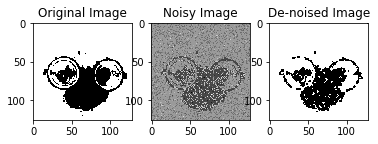

--------------------------------------------------
Gibbs Sampling Method:
Percent of pixels correct:  63.92 %
Iteration: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Final percent of pixels correct:  95.83 %


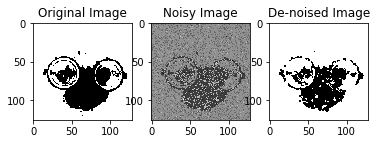

--------------------------------------------------
Gibbs Random Sampling Method:
Percent of pixels correct:  63.89 %
Iteration: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Final percent of pixels correct:  95.72 %


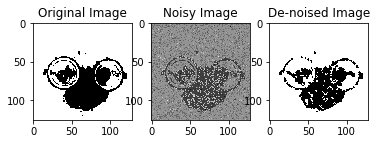

--------------------------------------------------
Variational Bayes Method:
Percent of pixels correct:  64.05 %
Iteration: 
1 2 3 4 5 6 7 8 9 10 11 12 13 Converged
Number of iterations to converge:  14
Final percent of pixels correct:  95.88 %


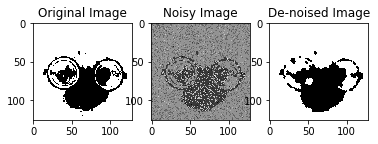

In [15]:
noise = [prop.value, varSigma.value, propSP.value]

consts = [h.value, beta.value, n.value]

plot_all_flag = 0
random_node_flag = 0

T = max_iterations.value # max number of iterations

run_ICM_val = run_ICM.value
run_Gibbs_val = run_Gibbs.value
run_GibbsRan_val = run_Gibbs.value
run_VB_val = run_VB.value

# run ICM
if run_ICM_val:
    print('Iterative Conditioning Model:')
    icm('pug-glasses.jpg',noise,consts,plot_all_flag)
    print('-'*50)

# run gibbs sampling
if run_Gibbs_val:
    print('Gibbs Sampling Method:')
    gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)
    print('-'*50)
    
# run gibbs sampling
if run_GibbsRan_val:
    random_node_flag = 1
    print('Gibbs Random Sampling Method:')
    gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)
    print('-'*50)

# run variational Bayes
if run_VB_val:
    print('Variational Bayes Method:')
    varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)
